# COVID-19 Case Data (San Bernardino)

Data provided by California Health and Human Services Open Data Portal: [California COVID-19 Hospital Data and Case Statistics](https://data.chhs.ca.gov/dataset/california-covid-19-hospital-data-and-case-statistics).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/covid19data.csv")

# Make index the date column.
df.index = pd.DatetimeIndex(df['Most Recent Date'])
df.sort_index(ascending = False)

,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients
Most Recent Date,,,,,,,,
2020-06-02,Yuba,06/02/2020,27.0,1.0,1.0,0.0,0.0,0.0
2020-06-02,Orange,06/02/2020,6790.0,150.0,306.0,92.0,130.0,18.0
2020-06-02,Napa,06/02/2020,116.0,3.0,0.0,2.0,0.0,0.0
2020-06-02,Monterey,06/02/2020,582.0,10.0,12.0,0.0,4.0,0.0
2020-06-02,Mono,06/02/2020,35.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2020-04-01,Napa,4/1/2020,11.0,0.0,2.0,2.0,0.0,1.0
2020-04-01,Shasta,4/1/2020,5.0,1.0,1.0,4.0,0.0,1.0
2020-04-01,Yolo,4/1/2020,22.0,1.0,3.0,3.0,1.0,1.0


In [2]:
df_sb = df[df['County Name'] == 'San Bernardino'].sort_index(ascending = False)

#Check data types of columns.
df_sb.dtypes

County Name                              object
Most Recent Date                         object
Total Count Confirmed                   float64
Total Count Deaths                      float64
COVID-19 Positive Patients              float64
Suspected COVID-19 Positive Patients    float64
ICU COVID-19 Positive Patients          float64
ICU COVID-19 Suspected Patients         float64
dtype: object

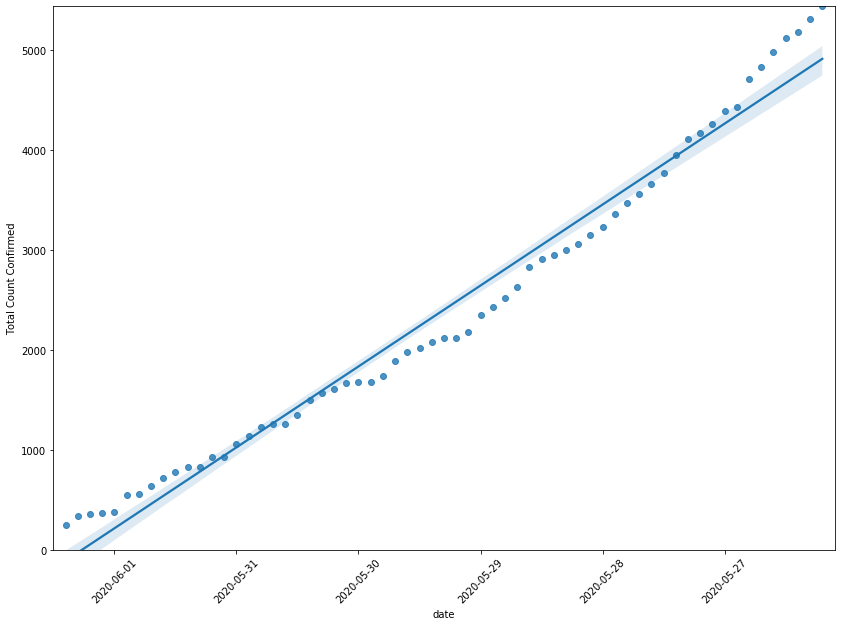

In [32]:
df_sb.sort_index()

df_sb['date_ordinal'] = pd.to_datetime(df_sb['Most Recent Date']).apply(lambda date: date.toordinal())

plt.figure(figsize=(14,10))
ax = sns.regplot(data=df_sb, x='date_ordinal', y='Total Count Confirmed')

# Tighten up the axes for prettiness
ax.set_xlim(df_sb['date_ordinal'].min() - 1, df_sb['date_ordinal'].max() + 1)
ax.set_ylim(0, df_sb['Total Count Confirmed'].max() + 1)

ax.set_xlabel('date')
new_labels = df_sb.index.date
ax.set_xticklabels(new_labels)
plt.xticks(rotation = 45)
plt.ylabel("Total Count Confirmed")

plt.show()

This graph seems to be relatively linear. However, note that there is a slight curve in this data.

> Should add graph fitting exponential model

In [4]:
# Generate column with new cases.

lag = df_sb['Total Count Confirmed'].shift(-1)
df_sb['New Confirmed Cases'] = df_sb['Total Count Confirmed'] - lag
df_sb.head(5)

,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,New Confirmed Cases
Most Recent Date,,,,,,,,,
2020-06-02,San Bernardino,06/02/2020,5438.0,208.0,156.0,70.0,63.0,13.0,128.0
2020-06-01,San Bernardino,06/01/2020,5310.0,204.0,148.0,69.0,62.0,17.0,125.0
2020-05-31,San Bernardino,05/31/2020,5185.0,204.0,136.0,73.0,53.0,10.0,63.0
2020-05-30,San Bernardino,05/30/2020,5122.0,204.0,130.0,95.0,52.0,12.0,139.0
2020-05-29,San Bernardino,05/29/2020,4983.0,199.0,134.0,95.0,50.0,13.0,152.0


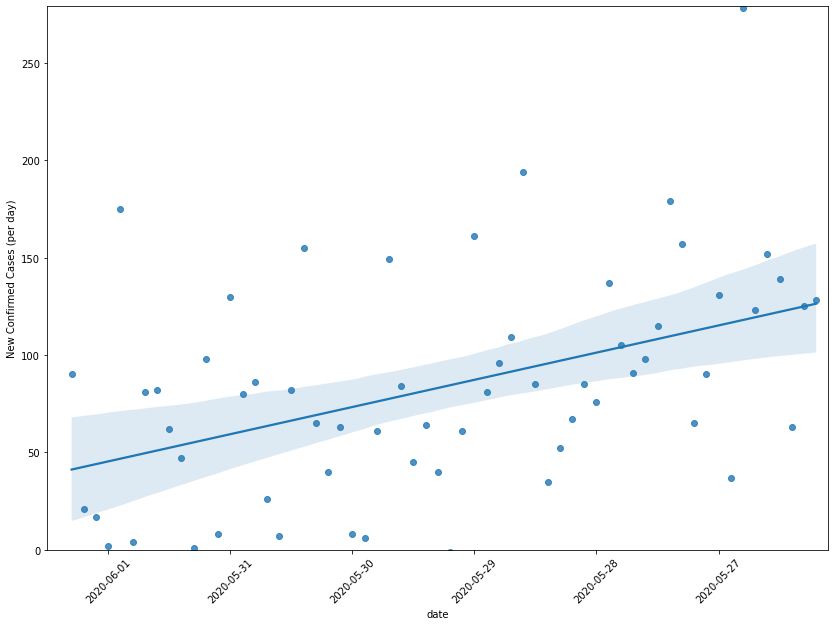

In [31]:
df_sb.sort_index()

df_sb['date_ordinal'] = pd.to_datetime(df_sb['Most Recent Date']).apply(lambda date: date.toordinal())

plt.figure(figsize=(14,10))
ax = sns.regplot(data=df_sb, x='date_ordinal', y='New Confirmed Cases')

# Tighten up the axes for prettiness
ax.set_xlim(df_sb['date_ordinal'].min() - 1, df_sb['date_ordinal'].max() + 1)
ax.set_ylim(0, df_sb['New Confirmed Cases'].max() + 1)

ax.set_xlabel('date')
new_labels = df_sb.index.date
ax.set_xticklabels(new_labels)
plt.xticks(rotation = 45)
plt.ylabel("New Confirmed Cases (per day)")

plt.show()

The data suggests an upward trend in confirmed cases per day in SB county over time.

> Add pearson corr.